# <span style="font-family: 'Computer Modern'; font-size: 42pt; font-weight: bold;">Quantum Convolutional Neural Network (QCNN): *Laboratory of Particle Physics and Cosmology (LPPC)*</span>

<style>
.small-break {
  margin-bottom: 5px; /* Adjust value to notebook needs */
  display: block;
}
</style>

## <span style="font-family: 'Computer Modern'; font-size: 26pt;">Introduction:</span>
<span style="font-family: 'Computer Modern'; font-size: 12pt;">This instructional notebook introduces a new Quantum Convolutional Neural Network (QCNN) model and Python package, built using the PennyLane framework and trained via Amplitude Embedding of imported MNIST data. This notebook walkthrough aims to introduce convolutional neural networks using foundational quantum computing ideas and operations, whether you are a researcher, student, or just interested in practicing with the field of quantum computing.</span>

## <span style="font-family: 'Computer Modern'; font-size: 26pt;">Background:</span>
<span style="font-family: 'Computer Modern'; font-size: 12pt;">The IceCube Neutrino Observatory generates a large daily data output, and while classical methods in machine learning have been effective, quantum computing offers the potential to analyze more data, avoiding bias by applying quantum entanglement operations to a given set of data and reducing this set to be trained only on its most relevant features. This QCNN model offers the possibility to work with the entirety of IceCube’s daily data output as a whole, without needing to resort to any data cuts.</span>

## <span style="font-family: 'Computer Modern'; font-size: 26pt;">Contents:</span>
<span style="font-family: 'Computer Modern'; font-size: 12pt;">

1. **Installation and Setup**

**(A) QCNN Package Dependencies:**
   - <code style="color: #00CED1;">Matplotlib</code>: Visualization
   - <code style="color: #00CED1;">Seaborn</code>: Enhanced visualizations
   - <code style="color: #00CED1;">Pennylane</code>: Quantum computing
   - <code style="color: #00CED1;">JAX</code>: High-performance numerical computing
   - <code style="color: #00CED1;">Optax</code>: Optimization (used in <code style="color: #FF8C00;">circuit_layers.py</code>)
   - <code style="color: #00CED1;">NumPy</code>: Numerical operations
   - <code style="color: #00CED1;">Pandas</code>: Data manipulation (used in <code style="color: #FF8C00;">circuit_layers.py</code>)
   - <code style="color: #00CED1;">Scikit-learn</code>: Dataset loading (used in <code style="color: #FF8C00;">load_qc_data.py</code>)
   - <code style="color: #00CED1;">Torch</code>: Data loading utilities (used in <code style="color: #FF8C00;">load_qc_data.py</code>)

**(B) Guidelines for Environment Setup:**
   - Configure JAX for CPU execution and 64-bit precision:
   - <code>jax.config.update('jax_platform_name', 'cpu')</code>
   - <code>jax.config.update("jax_enable_x64", True)</code>
   <div class="small-break"></div>

2. **Package Files Description**
   - <code style="color: #FF8C00;">circuit_layers.py</code>: Quantum circuit and layers construction, as well as training-related functions. Contains sets of each class for two different QCNN models, denoted by "QC" vs. "LPPC". This notebook makes use of the QC implementation.
   - <code style="color: #FF8C00;">load_qc_data.py</code>: Functions for loading, preparing, and managing data to be passed to the QCNN. This notebook imports MNIST data from <code style="color: #00CED1;">sklearn</code> to train the model, and uses <code style="color: #00CED1;">jax.numpy</code> and JIT-compiled functions for greater optimization in both this file and <code style="color: #FF8C00;">circuit_layers.py</code>.
   - <code style="color: #FF8C00;">qc_operators.py</code>: Functions for Gell-Mann matrices and relevant quantum operations.
   - <code style="color: #FF8C00;">setup.py</code>: Script for setting up the package.
   - <code style="color: #FF8C00;">__init__.py</code>: Initializes the package and its modules.
   - <code style="color: #FF8C00;">main.py</code>: Main entry point for running the application.
   <div class="small-break"></div>

3. **Basic Usage**
   - Importing package classes
   - Preparing MNIST data for quantum circuit
   - Creating and training QCNN model
   <div class="small-break"></div>

4. **Visualization and Analysis**
   - Tools for visualizing QCNN performance and results

</span>

## <span style="font-family: 'Computer Modern'; font-size: 26pt;">Sources:</span>
<span style="font-family: 'Computer Modern'; font-size: 12pt;">Much guidance and inspiration for this QCNN model was derived from an implementation presented in the following resource: <a href="https://github.com/Jaybsoni/Quantum-Convolutional-Neural-Networks/blob/main/qcnns_for_phase_recog/QCNNs%20for%20Classifying%20Quantum%20Phases%20of%20Matter.ipynb">QCNNs for Classifying Quantum Phases of Matter</a>.</span>

***


<span style="font-family: 'Computer Modern'; font-size: 14pt; font-weight: bold;">IMPORTS AND DEPENDENCIES:</span>

<span style="font-family: 'Computer Modern'; font-size: 12pt;">Relevant imports and dependencies for this QCNN construction include libraries for plotting and better visualization (Matplotlib and Seaborn), numerical computations with JIT compilation and differentiable programming (NumPy and JAX), and with specific stylistic selections applied for plotting aesthetics and configurations for JAX settings. Additionally, this QCNN relies on PennyLane for its framework for quantum computing operations.</span>

In [1]:
## Note:
## This notebook is an refined version of the package implementation of the QCNN notebook, designed for instructional 
## and learning purposes. It includes detailed guidance and documentation to facilitate your understanding of the 
## QCNN model, its construction, and its and operations.

In [2]:
#### ***** IMPORTS / DEPENDENCIES *****:

### *** PLOTTING ***:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
import seaborn as sns
sns.set()

### *** PENNYLANE ***:
import pennylane as qml
from pennylane import numpy as np

### *** JAX ***:
import jax;
## JAX CONFIGURATIONS:
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

<hr style="border: none; border-top: 2px dashed currentColor;">

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 24pt;">LOADING MNIST DATASET</span>

<span style="font-family: 'Computer Modern'; font-size: 12pt;">This model starts first with setting up the QCNN environment by defining the number of qubits and wires to be passed to the quantum circuit, and selecting a quantum device for the QCNN. For this model, we set the number of qubits equal to six and instantiate our quantum device using the 'default.qubit.jax' simulator from PennyLane, printing the device name to confirm our selection. In this case, we use a JAX device due to the package's frequent use of JAX, JAX's NumPy, and JIT-compiled functions for efficient computation.</span>

In [3]:
# ********************************************
#           INITIAL PARAMETER SETUP
# ********************************************

## IMPORTING DATA LOADING CLASS:
from lppc_qcnn.load_qc_data import LoadDataQC

## *** DEFINE VARIABLES (QUBITS) ***:
# =======================================================
n_qubits = 6 # Number of qubits (six-qubit device)
active_qubits = list(range(n_qubits))  # Active qubits
num_wires = 6 # Number of wires
# =======================================================

## SELECT QUANTUM DEVICE:
# Quantum device for QCNN (currently uses jax device for optimization):
device = qml.device('default.qubit.jax', wires=num_wires)
print(f"SELECTED DEVICE: {device.short_name} \u2713") # Confirm device selection
print(f"{'-'*37}")

SELECTED DEVICE: default.qubit.jax ✓
-------------------------------------


<span style="font-family: 'Computer Modern'; font-size: 12pt;">We then initialize a random number generator (RNG) for the QCNN, choosing between JAX or NumPy based on the selected <code>rng_type</code>. In this case, our use of <code style="color: #00CED1;">jax.numpy</code> and JIT-compiled functions warrants the use of JAX's PRNGKey with <code>seed=0</code>, converts this key to a JAX array, and prints the RNG type to confirm the selection.</span>

In [4]:
#### ***** RANDOM NUMBER GENERATOR *****:
seed = 0
rng_type = "jax" # Select rng for data processing (qcnn uses jax rng with 'PRNGKey')
# ------------------------------------------------------------------------------------
if rng_type == "jax":
    rng_jax = jax.random.PRNGKey(seed=seed) # Base (JAX)
    rng_jax_arr = jnp.array(rng_jax) # Base as array (JAX)
    print(f"SELECTED RNG TYPE: {type(rng_jax)} \u2713") # Confirm JAX rng selection
    print(f"{'-'*62}")
else:
    rng = np.random.default_rng(seed=seed) # Base (NP)
    print(f"SELECTED RNG TYPE: {type(rng)} \u2713")  # Confirm NumPy rng selection
    print(f"{'-'*60}")
# ------------------------------------------------------------------------------------

SELECTED RNG TYPE: <class 'jaxlib.xla_extension.ArrayImpl'> ✓
--------------------------------------------------------------


<span style="font-family: 'Computer Modern'; font-size: 12pt;">This RNG can then be used to divide the imported data into random training and testing subsets. We set <code>n_train_data</code> and <code>n_test_data</code> equal to 2, importing 2 images each for the train and test sets. This model then prepares the data by loading and transforming it using regular NumPy operations, and then converts the features and labels to jax.numpy arrays before fully instantiating <code>x_train</code>, <code>y_train</code>, <code>x_test</code>, and <code>y_test</code> using the <code>load_digits_data_jax</code> function.</span>

In [5]:
# ********************************************
#          LOADING THE MNIST DATASET
# ********************************************

## *** DEFINE VARIABLES (DATA/IMAGES) ***:
# =======================================================
n_train_data = 2 # Number of TRAIN images for data
n_test_data = 2 # Number of TRAIN images for data
# =======================================================

# Prepare data by completing NumPy operators before casting with JAX:
features_np, labels_np = LoadDataQC.prepare_data()

# Convert to JAX arrays:
features = jnp.array(features_np)
labels = jnp.array(labels_np)

## JAX DATA CONFIGURATION:
# -------------------------------------------------------------------------------------------------
x_train, y_train, x_test, y_test = LoadDataQC.load_digits_data_jax(n_train=n_train_data,
                                            n_test=n_test_data, features=features, labels=labels)
# -------------------------------------------------------------------------------------------------

<span style="font-family: 'Computer Modern'; font-size: 12pt;">Below checks that the MNIST data has been imported correctly by checking the shapes and types of the training and testing data, as well as their labels. It also confirms that the data is normalized prior to passing to the QCNN, and also checks that the number of unique labels are correct, as this model trains based on binary classification.</span>

In [6]:
##                        ***** FUNCTIONALITY CHECK (DATA) *****
# -----------------------------------------------------------------------------------------
print(f"{'='*15} FUNCTIONALITY CHECK (DATA) {'='*15}")

# Shapes and Types:
print(f"\n{'='*14} (1) SHAPES AND TYPES {'='*14}")
print(f"• x_train type:  {type(x_train)}  | shape:  {x_train.shape}")
print(f"• y_train type:  {type(y_train)}  | shape:  {y_train.shape}")
print(f"• x_test type:  {type(x_test)}  | shape:  {x_test.shape}")
print(f"• y_test type:  {type(y_test)}  | shape:  {y_test.shape}")

# Normalization:
print(f"\n{'='*10} (2) NORMALIZATION {'='*10}")
print(f"• x_train first row norm:  {jnp.linalg.norm(x_train[0])}") # (JAX)
print(f"• x_test first row norm:  {jnp.linalg.norm(x_test[0])}") # (JAX)

# Label Uniqueness:
print(f"\n{'='*10} (3) LABEL UNIQUENESS {'='*10}")
print(f"• Unique labels -> y_train:  {jnp.unique(y_train, size=2, fill_value=1)}") # (JAX)
print(f"• Unique labels -> y_test:  {jnp.unique(y_test, size=2, fill_value=1)}") # (JAX)
# -----------------------------------------------------------------------------------------

=============== FUNCTIONALITY CHECK (DATA) ===============

============== (1) SHAPES AND TYPES ==============
• x_train type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (2, 64)
• y_train type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (2,)
• x_test type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (2, 64)
• y_test type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (2,)

========== (2) NORMALIZATION ==========
• x_train first row norm:  0.9999999999999999
• x_test first row norm:  0.9999999999999999

========== (3) LABEL UNIQUENESS ==========
• Unique labels -> y_train:  [0 1]
• Unique labels -> y_test:  [0 1]


<span style="font-family: 'Computer Modern'; font-size: 12pt;">A sample image of the MNIST dataset can be seen below. More specifically, it displays the first 12 images in a 1x12 grid. The MNIST dataset is a large set of handwritten, grayscaled images of digits, an is a common dataset used to train machine learning models:</span>

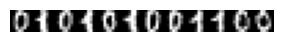

In [7]:
#### ***** DRAW MNIST DATA SUBSET IMAGE *****:
LoadDataQC.draw_mnist_data()

***

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 24pt;">CONSTRUCTING QUANTUM CIRCUIT</span>

<span style="font-family: 'Computer Modern'; font-size: 12pt;">Now that the relevant MNIST data has been properly imported and prepared for application to the QCNN, we can now construct the circuit at hand. Our optimized quantum circuit is initialized by <code>conv_net</code>, and below is a circuit drawing of the associated QC. We define a set of sample weights and features to construct the drawing, and set <code>num_wires_draw</code> equal to six, the number of qubits that will be used in the QCNN. A more detailed description of the operations of this quantum circuit can be found directly after the circuit drawing, and drawings of the convolutional and pooling layers can be found in the appendix section of this notebook.</span>

In [8]:
# ********************************************
#    VISUALIZING / PLOTTING QUANTUM CIRCUIT
# ********************************************

## IMPORTING QUANTUM CIRCUIT LAYERS CLASS:
from lppc_qcnn.circuit_layers import LayersQC
layers_obj = LayersQC()

## DEFINE SAMPLE WEIGHTS / FEATURES FOR CONV_NET:
# (Note: these weights and features are only sample arrays of similar shape to the actual weights and features. The ones
# defined below are used only in relation to circuit drawing needs.)
num_wires_draw = 6 # Number of wires (DRAWINGS)
weights = np.random.rand(81, 2) # <-- Shape ~ [(num_wires // 2) * (3 ** 3)]
last_layer_weights = np.random.rand(4 ** 2 - 1)
features = np.random.rand(2 ** num_wires_draw)

/Users/seanchisholm/VSCode_LPPC/qcnn-lppc/.conda/lib/python3.11/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/Users/seanchisholm/VSCode_LPPC/qcnn-lppc/.conda/lib/python3.11/site-packages/pennylane/drawer/mpldrawer.py:581: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  bbox = text_obj.get_window_extent(renderer)


========================= QCNN QUANTUM CIRCUIT =========================


/Users/seanchisholm/VSCode_LPPC/qcnn-lppc/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


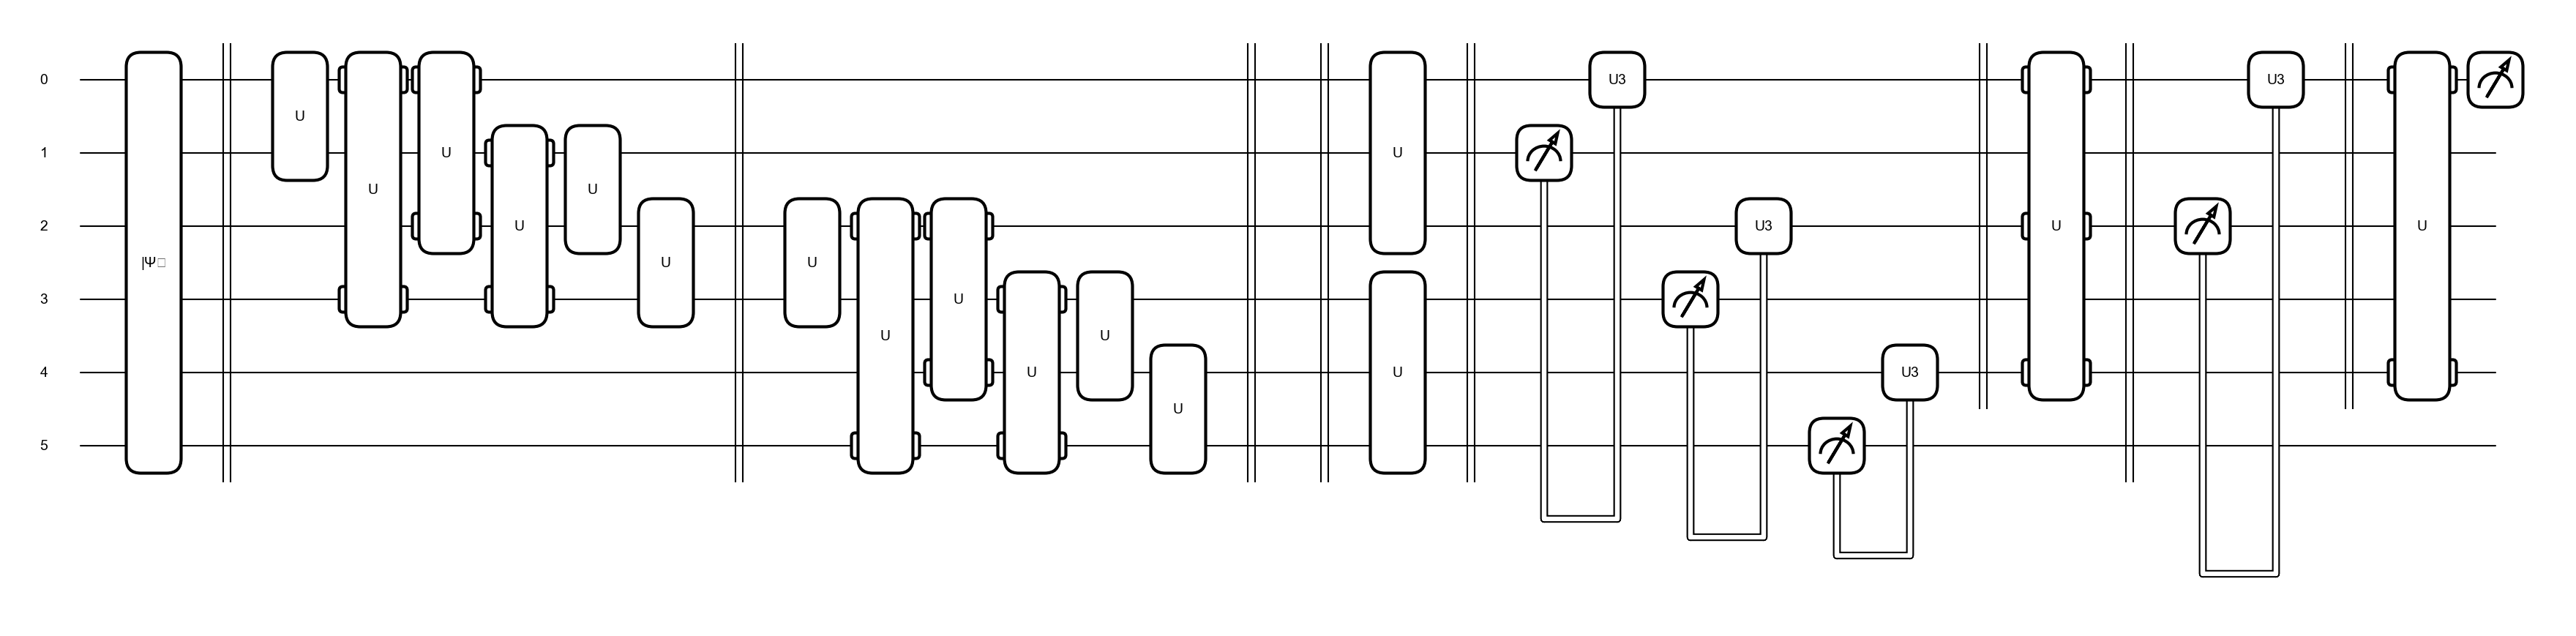

In [9]:
## DRAWING THE QUANTUM CIRCUIT:
fig, ax = qml.draw_mpl(layers_obj.conv_net)(
    layers_obj, weights, last_layer_weights, features
)

print(f"{'='*25} QCNN QUANTUM CIRCUIT {'='*25}")
plt.show()

<span style="font-family: 'Computer Modern'; font-size: 14pt; font-weight: bold;">CIRCUIT DESCRIPTION:</span>

<span style="font-family: 'Computer Modern'; font-size: 12pt;">Above is a figure out the construction of the Quantum Convolutional Neural Network (QCNN) for a six-qubit convolution. It begins with embedding the input data using PennyLane's <code>AmplitudeEmbedding</code>, and then passes the embedded data into the circuit. The circuit itself is a series of convolutional and pooling layers iteratively across decreasing sets of qubits. After these layers, a final fully-connected dense layer is applied that entangles the remaining qubits and returns the probability distribution of the remaining qubit with <code>qml.probs</code>, effectively reducing the dataset to its most essential information. The functionality of the layers is as follows:</span>

- <code style="color: #66CDAA;">Convolutional Layer</code>: <span style="font-family: 'Computer Modern'; font-size: 12pt;">This layer applies a sequence of unitary operations to the active qubits in the QC, to extract relevant quantum features from the inputted MNIST data. The first conv layer, <code>four_conv_layer</code>, uses Gell-Mann matrices to construct unitary operators that are applied to the qubits in groups of 4 (in this case, the function has the option to skip the first layer, which is applied here since we are using a six-qubit system). Subsequent layers use <code>three_conv_layer</code>, which also relies on Gell-Mann matrices to generate unitary operators, but are applied in groups of 3.</span>
    <div class="small-break"></div>
- <code style="color: #66CDAA;">Pooling Layer</code>: <span style="font-family: 'Computer Modern'; font-size: 12pt;">This layer then applies operations to the convolved data with the <code>pooling_layer</code> function to downsample the dataset. It measures specific qubits and conditionally applies U3 unitary gates to other qubits based on the measurement outcome(s). The purpose of the pooling layer is precisely to reduce the dimensionality of the quantum data by preserving the most relevant features, allowing it to process more data in a typically shorter time than a classical convolutional neural network (CNN).</span>
    <div class="small-break"></div>
- <code style="color: #66CDAA;">Dense Layer</code>: <span style="font-family: 'Computer Modern'; font-size: 12pt;">This layer then applies an arbitrary unitary gate, constructed again using Gell-Mann matrices, to the remaining qubits. It is the equivalent of a fully connected layer in a CNN, combining all of the downsampled relevant features into one singular quantum state. After this layer, final measurements are taken with <code>qml.probs</code>, and our circuit is complete.</span>

***

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 24pt;">TRAINING MNIST DATA ON QUANTUM CIRCUIT</span>

<span style="font-family: 'Computer Modern'; font-size: 12pt;">We are then ready to train our quantum circuit on the MNIST data. We instantiate the desired values for <code>n_train</code> and <code>n_test</code>, as well as for the number of epochs and repetitions with <code>n_epochs</code> and <code>n_reps</code>. The computation/training process initializes trainable parameters and loads the dataset first, and then initiates the training loop. It computes the training cost and gradients, updates the weights using the optimizer, and records the training cost. It also calculates and records the training accuracy. It then computes the test outputs, evaluates the test accuracy, and records it along with the evaluated test cost. Our QCNN model will go through the entire training dataset for <code>n_epochs</code> amount of times, updating the weights after each pass based on the computed gradients. It then repeats this process for an <code>n_reps</code> number of times, each time starting with newly initalized and untrained weights. We can then average out these repetitions to get a clearer understanding of the model's efficiency.</span>

In [10]:
# ********************************************
#           TRAINING QCNN / RESULTS
# ********************************************

## RELEVANT CLASS IMPORTS:
from lppc_qcnn.circuit_layers import TrainQC  # TrainQC() <--- STATIC METHOD (WITH JAX)

## *** DEFINE VARIABLES (TRAINING) ***:
# =======================================================
n_train = 5
n_test = 10
n_epochs = 100
n_reps = 10
# =======================================================

# TRAIN QCNN -> RESULTS:
results_df = TrainQC.compute_aggregated_results(n_train=n_train, n_test=n_test, n_epochs=n_epochs, n_reps=n_reps)

<span style="font-family: 'Computer Modern'; font-size: 12pt;">Below checks that the QCNN has successfully performed its training loop using the MNIST data. It prints the training cost, training accuracy, testing cost, and testing accuracy at every 100th step, starting at the zero index, for <code>n_epochs=100</code> and <code>n_reps=10</code>.</span>

In [11]:
##         ***** FUNCTIONALITY CHECK (TRAINING) *****
# -----------------------------------------------------------------------------------------
indices = list(range(99, 1000, 100)) # indices for every 100th step (starting from 0)
indices.insert(0, 0) # Add zero to beginning of list

# Use indices to filter DataFrame:
filtered_df = results_df.iloc[indices]
## PRINT:
print(f"\n{'='*31} QCNN RESULTS {'='*32}\n")
print(filtered_df)
# -----------------------------------------------------------------------------------------


=============================== QCNN RESULTS ================================

    train_acc           train_cost test_acc            test_cost step n_train
0         1.0   0.4813534044988193      0.9  0.42101148634874774    1       5
99        1.0  0.15351526217859396      1.0  0.21822740020137188  100       5
199       1.0  0.15351526217859396      1.0  0.21822740020137188  100       5
299       1.0  0.15351526217859396      1.0  0.21822740020137188  100       5
399       1.0  0.15351526217859396      1.0  0.21822740020137188  100       5
499       1.0  0.15351526217859396      1.0  0.21822740020137188  100       5
599       1.0  0.15351526217859396      1.0  0.21822740020137188  100       5
699       1.0  0.15351526217859396      1.0  0.21822740020137188  100       5
799       1.0  0.15351526217859396      1.0  0.21822740020137188  100       5
899       1.0  0.15351526217859396      1.0  0.21822740020137188  100       5
999       1.0  0.15351526217859396      1.0  0.218227400201371

***

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 24pt;">RESULTS</span>

<span style="font-family: 'Computer Modern'; font-size: 14pt; font-weight: bold;">QCNN TRAINING VISUALIZATION:</span>

<span style="font-family: 'Computer Modern'; font-size: 12pt;">After training, we can generate plots of the aggregated training results for the quantum circuit with <code>plot_aggregated_results</code>. Below shows he training and test losses (left) and accuracies (right) over 100 epochs for different potential training sizes, with <code>n_train=2</code>, <code>n_train=5</code>, and <code>n_train=10</code>, organized by color. The figures below demonstrate the successful training and convergence of our QCNN model, ready to be applied to other datasets.</span>

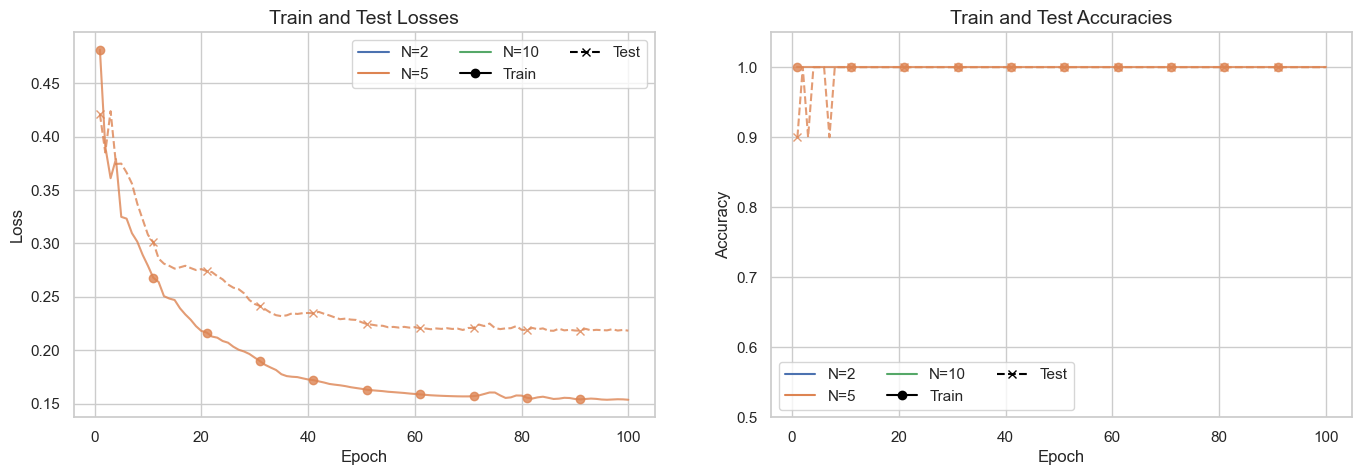

In [12]:
# ********************************************
#     PLOTTING AGGREGATED TRAINING RESULTS
# ********************************************

# Plot aggregated training results:
TrainQC.plot_aggregated_results(results_df, n_train, steps=n_epochs, 
                                  title_loss='Train and Test Losses', 
                                  title_accuracy='Train and Test Accuracies', 
                                  markevery=10)

***

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 24pt;">APPENDIX</span>

<span style="font-family: 'Computer Modern'; font-size: 12pt;">This appendix provides detailed figure diagrams representing the specific layers that appear within the quantum convolutional neural network (QCNN) structure, including its convolutional and pooling layers, for greater clarity on the quantum circuit's specific operations.</span>

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 16pt;">Relevant QCNN Circuit Drawings:</span>

================== QCNN CONVOLUTIONAL LAYER CIRCUIT ==================


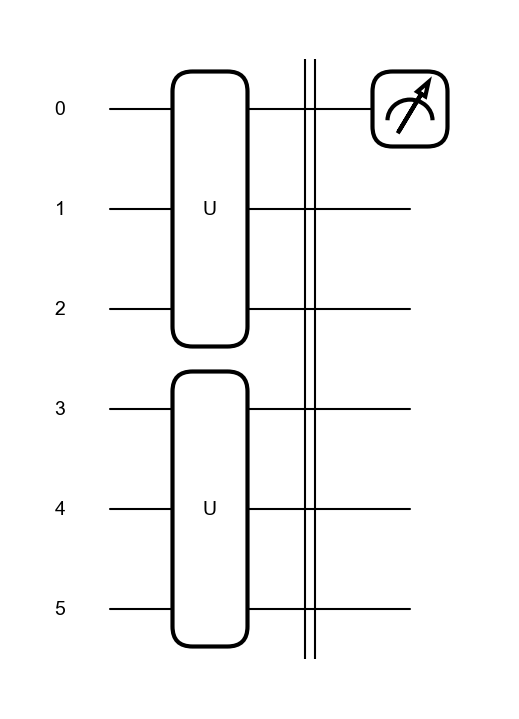

In [13]:
## DEFINE SAMPLE WEIGHTS / FEATURES FOR THREE_LAYER_CONV:
# (Note: these qubits and params are only sample arrays of similar shape to the actual qubits and params. The ones
# defined below are used only in relation to circuit drawing needs.)
n_qubits_draw = 6  # Number of qubits
active_qubits_draw = list(range(n_qubits_draw))  # Active qubits
params_draw = weights[:, 0]  # (Note: Use appropriate slicing based on drawing needs)

## DRAWING THE CONVOLUTIONAL LAYER (CIRCUIT):
fig, ax = qml.draw_mpl(layers_obj.three_layer_conv_circuit)(
layers_obj, params_draw, active_qubits_draw
)

print(f"{'='*18} QCNN CONVOLUTIONAL LAYER CIRCUIT {'='*18}")
plt.show()

/Users/seanchisholm/VSCode_LPPC/qcnn-lppc/.conda/lib/python3.11/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


============================== QCNN CONVOLUTIONAL AND POOLING LAYER CIRCUIT ==============================


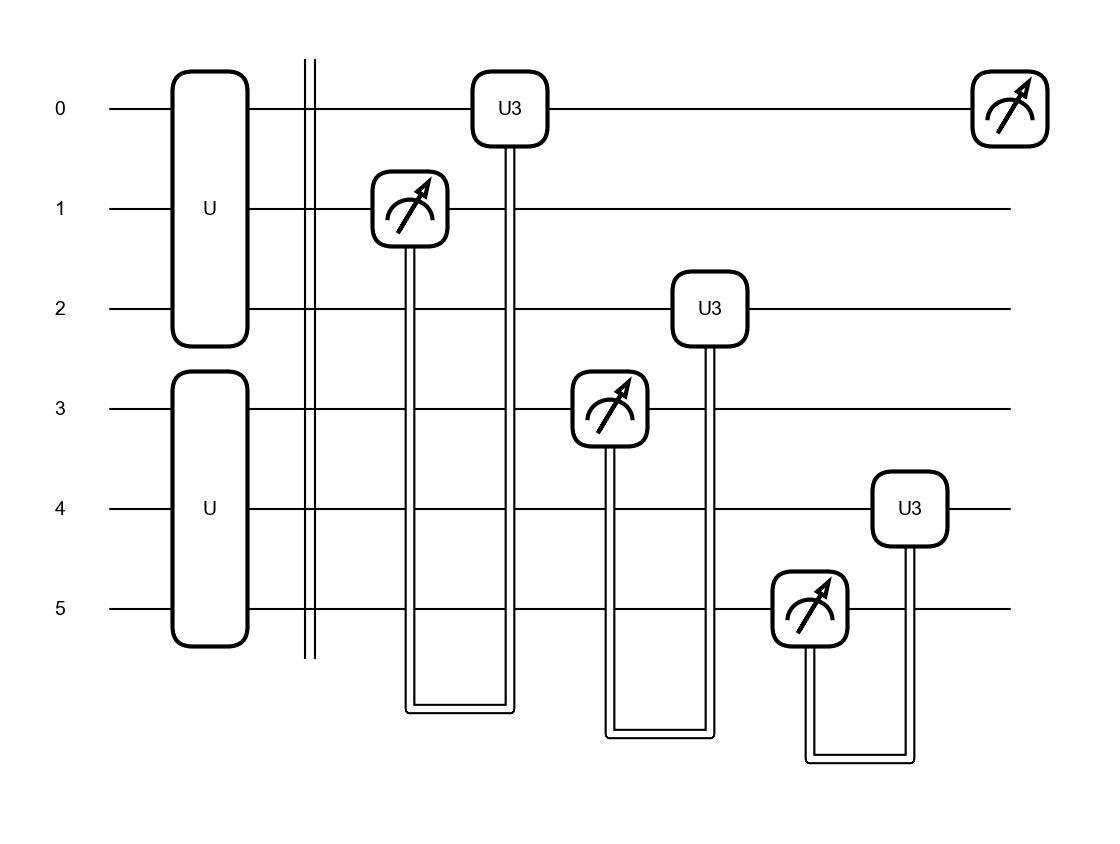

In [14]:
## DRAWING THE CONVOLUTIONAL AND POOLING LAYER (CIRCUIT):
fig, ax = qml.draw_mpl(layers_obj.conv_and_pooling_circuit)(
layers_obj, params_draw, active_qubits_draw
)

print(f"{'='*30} QCNN CONVOLUTIONAL AND POOLING LAYER CIRCUIT {'='*30}")
plt.show()

***